In [1]:
import numpy as np
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from keras.applications import VGG16

import cv2

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [46]:
# this thing is giving me errors for some reason
from CAM import get_class_activation_map

from keras.backend import function
def get_class_activation_map(model, image_path, num_classes):
    ''' (keras.Model, str, int) -> ndarray
    Returns the class activation map of the given image, evaluated on the given keras model. We need the 
    number of output classes to determine dimension of the weights in the final layer.

    Class activation map is a unsupervised way of doing object localization with accuracy near par
    with supervised methods
    '''

    original_img = plt.imread(image_path) / 255

    #Reshape into 4d tensor
    img = np.expand_dims(original_img, axis=0)

    #Get the 512 input weights to the final layer 
    class_weights = model.layers[-1].get_weights()[0]

    # variables for easy access to needed layers
    input_layer = model.layers[0]
    final_layer = model.layers[-1]
    final_conv_layer = model.layers[-4]

    # a function that takes in the input layer, a tensor of shape (?, ?, ?, 3), and outputs the feature maps
    # after the last convolutional layer
    get_output = function([input_layer.input], [final_conv_layer.output])

    # call function on our image to get feature maps 
    conv_outputs = get_output([img])
    conv_outputs = conv_outputs[0][0] # [0][0] --> a list with one item. 4d tensor to 3d tensor

    # #Create the class activation map.
    # we create an empty ?x? array where ? and ? are the dimensions of our feature maps
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])

    # vectorized and non-vectorized code

    # 1. VECTORIZED

    # multiply length/width feature map dimensions
    width_times_len = conv_outputs.shape[0]*conv_outputs.shape[1] 
    # our output shape will be the same as our feature map dimensions (w/o # of maps)
    output_shape = conv_outputs.shape[:2] 
    # reshape into 2d
    temp = conv_outputs.reshape((width_times_len,conv_outputs.shape[2])) 
    # multiply all our feature maps with its corresponding weights
    # reshape to class activation map
    cam = np.matmul(temp, class_weights).reshape(output_shape)

    #
    #
    #

    # 2. NON-VECTORIZED

#     # loop num_classes amount of times
#     for curr_class in range(num_classes):

#         # for each class, multiply its class weights with all of the feature maps 
#         # sum it all up (by continuously adding it to our class activation map array)

#         # our class weights are ?xnum_classes (where ? is the number of feature maps from final conv layer)
#         for idx, weight in enumerate(class_weights[:, curr_class]):
#                  cam += weight * conv_outputs[:, :, idx]

    # example:
    # say class weights are 512x1 (512 feature maps from final conv layer to a binary class sigmoid)
    # our conv_outputs is 8x8x512 in this example. each feature map is 8x8
    # loop through each 512 weights and multiply it with its corresponding 8x8 feature map (scalar * matrix)

    return cam

# to view heatmap, call plt.imshow(cam) 

In [47]:
# load model
model = load_model('VGG16_trained.h5')

In [48]:
IMG_PATH = 'test_dog_image.jpg'
WIDTH = 128
HEIGHT = 128

In [49]:
# scale and make picture into 4d tensor
test_pic = plt.imread(IMG_PATH) / 255
test_pic = np.expand_dims(test_pic, axis=0)
test_pic.shape

(1, 128, 128, 3)

In [50]:
# predict
# got ~61% that it was a dog

pred = model.predict(test_pic)[0][0]
pred

0.60542548

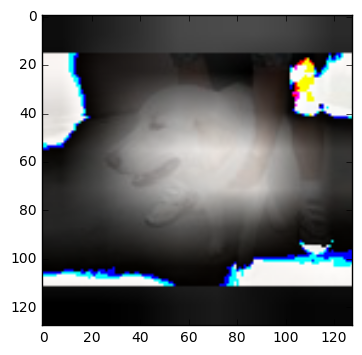

In [ ]:
test_pic = plt.imread(IMG_PATH) / 255

cam = get_class_activation_map(model, IMG_PATH, 1)

# overlay cam with original
# scale cam to image size
cam = cv2.resize(cam, (WIDTH, HEIGHT)) 
# make into 3 channels for overlay compatibility purposes
cam = cv2.cvtColor(cam, cv2.COLOR_GRAY2RGB)
# scale
cam = cam / np.max(cam)

# make both images have same data types
test_pic = test_pic.astype(np.float64)
cam = cam.astype(np.float64)

# show overlayed image
img = cv2.addWeighted(cam, 0.8, original_pic, 0.2, 0)
plt.imshow(img)

In [ ]:
cv2.putText(
    img, # put text on this image
    "Confidence",
    (5,20),# left offset, top offset
    cv2.FONT_HERSHEY_SIMPLEX, # font family
    0.7, # scale of text size
    (0,255,0), # color
    1, # line width
    cv2.LINE_AA # line type
)

cv2.putText(
    img, # put text on this image
    "{:.2f}".format(pred*100), # text two decimal places (https://mkaz.tech/code/python-string-format-cookbook/)
    (5,35),# left offset, top offset
    cv2.FONT_HERSHEY_SIMPLEX, # font family
    0.5, # scale of text size
    (0,255,0), # color
    1, # line width
    cv2.LINE_AA # line type
)


cv2.imshow('CAM', img)
cv2.waitKey(0)